# Data Analysis - MODS207
## Authors: José Lucas Barretto and Lucas Miguel Celinga Agrizzi

The goal of this notebook is to explore the collected data, visualize it to acquire insights, and run regression models.

### Data Preparation

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
import statsmodels.api as sm
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [27]:
# read processed data
df_cities_static = pd.read_csv('../data/proc_data/cities_static.csv.zip', index_col=0)
df_cities_temp = pd.read_csv('../data/proc_data/cities_temp.csv.zip', parse_dates=[3], index_col=0)

In [28]:
# merge important data into one dataframe
df_cities_temp['city_code'] = df_cities_temp['city_code'].astype(int)
df = pd.merge(df_cities_temp, df_cities_static[['city_code', 'population']], on='city_code', how='left')

In [29]:
# prepare withdrawal data to account for the delayed effect of covid contamination
days_to_confirmation_avg = 6
days_to_confirmation_std = 4

# shift withdrawal dates
shifted_withdrawal = pd.DataFrame()
shifted_withdrawal['withdrawal_lagged'] = df['withdrawal']
shifted_withdrawal['city_code'] = df['city_code']
dates = df['date']
shifted_withdrawal['date'] = dates + pd.Timedelta(days=days_to_confirmation_avg)
df = pd.merge(df, shifted_withdrawal, on=['city_code', 'date'], how='left')

# apply gaussian smoothing
df['withdrawal_lagged_smooth'] = df.groupby('city_code')['withdrawal_lagged'].rolling(
    20,
    min_periods=1,
    win_type='gaussian',
    center=True
).mean(std=days_to_confirmation_std).values

In [30]:
# smooth covid variables
df['confirmed_day_smooth'] = df.groupby('city_code')['confirmed_day'].rolling(window=7).mean().values
df['deaths_day_smooth'] = df.groupby('city_code')['deaths_day'].rolling(window=7).mean().values

In [31]:
# drop NaN values from dataset
df.dropna(inplace=True)

### Descriptive Data Statistics

#### Number of Instances: 

For this part of the study, we will consider cities in the brazilian states of São Paulo and Bahia, where we have municipality level data. Note that not all dates are available for all cities, so we're going to give some descriptive stats on the time frame as well.

In [46]:
print('Total number of instances:', len(df))
print('Number of cities:', len(df['city_code'].unique()))

dates_descriptive = df['date'].describe(datetime_is_numeric=False)
print('Number of unique dates:',  dates_descriptive['unique'])
print('Date range:', dates_descriptive['first'].date(), 'to', dates_descriptive['last'].date())

Total number of instances: 141220
Number of cities: 556
Number of unique dates: 352
Date range: 2020-03-03 to 2021-02-26


#### Descriptive Statistics by Variable:

##### Covid Variables:

In [66]:
covid_df = df[[
    'confirmed_day',
    'deaths_day',
]].div(df['population'], axis=0)*100000

covid_df.rename(
    columns={'confirmed_day': 'daily cases (per 100000)', 'deaths_day': 'daily deaths (per 100000)'},
    inplace=True
)

covid_df.describe()

,daily cases (per 100000),daily deaths (per 100000)
count,141220.000000,141220.000000
mean,13.272304,0.241017
std,25.247115,1.046385
min,0.000000,0.000000
25%,0.000000,0.000000
50%,4.550448,0.000000
75%,16.197119,0.000000
max,1506.822738,35.932447


##### Telecommunication Variables:

In [67]:
telecom_df = df[[
    'cable_tv_accesses',
    'fixed_bandwidth_accesses',
    'fixed_telephony_accesses',
    '2G_mobile_accesses',
    '3G_mobile_accesses',
    '4G_mobile_accesses'
]].div(df['population'], axis=0)*100000

telecom_df.rename(
    columns={col_name: (col_name + ' (per 100000)') for col_name in telecom_df.columns},
    inplace=True
)

telecom_df.describe()

,cable_tv_accesses (per 100000),fixed_bandwidth_accesses (per 100000),fixed_telephony_accesses (per 100000),2G_mobile_accesses (per 100000),3G_mobile_accesses (per 100000),4G_mobile_accesses (per 100000)
count,141220.000000,141220.000000,141220.000000,141220.000000,141220.000000,141220.000000
mean,5434.561082,10003.775445,14193.907375,8482.866823,11305.564153,53283.276527
std,5530.301526,10498.538551,16959.555330,25130.242544,19263.703531,31564.768939
min,74.043603,189.831628,294.299141,357.483317,1755.058246,8316.314953
25%,1106.471816,2241.010492,2477.113624,4265.896881,6395.173958,30167.209067
50%,3753.971543,5777.260881,5193.995278,5923.725142,8409.117123,44432.353792
75%,7627.096939,15661.240558,23523.549104,8477.734302,10619.913128,72355.648536
max,32872.230141,226039.010173,114827.169322,938882.663856,462844.905752,494347.031963


##### Social Withdrawal

In [69]:
withdrawal_df = df[[
    'withdrawal'
]].div(df['population'], axis=0)

telecom_df.describe()

,withdrawal
count,1.412200e+05
mean,1.837161e-05
std,1.789469e-05
min,2.463688e-08
25%,5.272910e-06
50%,1.315390e-05
75%,2.602780e-05
max,1.729958e-04


### Visualizations and Analyses

#### Social Isolation Effect on the Covid-19 Pandemic

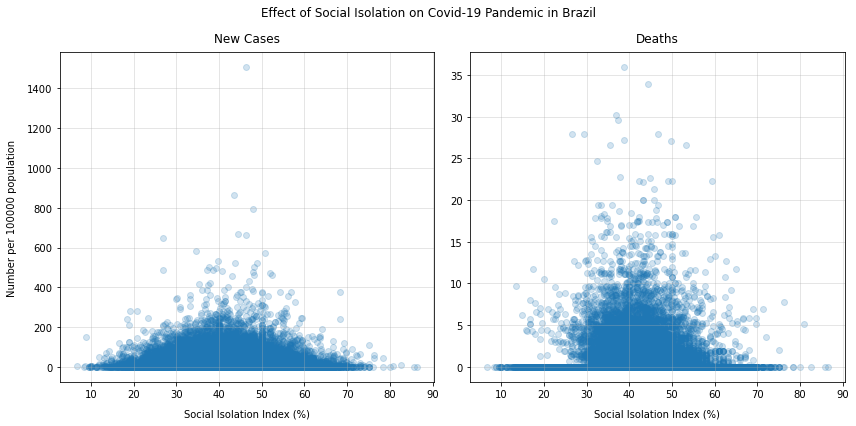

In [92]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

new_cases_pc = df['confirmed_day'].div(df['population'])
deaths = df['deaths_day'].div(df['population'])
withdrawal = df['withdrawal']

ax1.scatter(withdrawal*100, new_cases_pc*100000, alpha=0.2)
ax1.set_xlabel('Social Isolation Index (%)', labelpad=10)
ax1.set_ylabel('Number per 100000 population', labelpad=10)
ax1.set_title('New Cases', pad=10)
ax1.grid(alpha=0.4)

ax2.scatter(withdrawal*100, deaths*100000, alpha=0.2)
ax2.set_xlabel('Social Isolation Index (%)', labelpad=10)
ax2.set_title('Deaths', pad=10)
ax2.grid(alpha=0.4)

fig.suptitle('Effect of Social Isolation on Covid-19 Pandemic in Brazil')
plt.tight_layout()
plt.show()

In this study, we use the social isolation index as a proxy for how the population is respecting social distance, and as a result of governmental policies. We can see that for social isolation ratings higher than 40%, both the number of new daily cases and the number of deaths are inversely correlated with isolation. This shows that social distance is indeed positive for containing the spread of the virus.

However, if we look at the death and new cases rates at the lower end of the isolation index, we notice a positive correlation. This may be due to the fact that when the number of cases is low, people start to go out and the government loosens restrictions, leading to an increase in the number of cases.

### Regressions

#### Panel OLS - Deaths per capita x Social Withdrawal

In [81]:
y = df.loc[:,['city_code', 'date']]
y['confirmed_day_pc'] = df['confirmed_day_smooth'].div(df['population'])
y.set_index(['city_code', 'date'], inplace=True)

In [82]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_lagged_smooth']])
X.set_index(['city_code', 'date'], inplace=True)

In [ ]:
model = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = model.fit(cov_type='clustered')
print(res)

#### Panel OLS - Deaths per capita x (Telecommunications + Social Withdrawal)

In [72]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_lagged_smooth']])
X['fixed_bandwidth'] = df['fixed_bandwidth_accesses'].div(df['population'])
X.set_index(['city_code', 'date'], inplace=True)

In [74]:
model = PanelOLS(y, X, entity_effects=False, time_effects=False)
res = model.fit(cov_type='clustered')
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:       confirmed_day_pc   R-squared:                        0.0143
Estimator:                   PanelOLS   R-squared (Between):              0.0509
No. Observations:              132702   R-squared (Within):               0.0036
Date:                Sat, May 29 2021   R-squared (Overall):              0.0143
Time:                        18:30:52   Log-likelihood                 9.696e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      960.48
Entities:                         556   P-value                           0.0000
Avg Obs:                       238.67   Distribution:                F(2,132699)
Min Obs:                       8.0000                                           
Max Obs:                       325.00   F-statistic (robust):             736.85
                            

In [75]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_lagged_smooth']])
X['fixed_bandwidth'] = df['fixed_bandwidth_accesses'].div(df['population'])
X['cable_tv'] = df['cable_tv_accesses'].div(df['population'])
X.set_index(['city_code', 'date'], inplace=True)

model = PanelOLS(y, X, entity_effects=False, time_effects=False)
res = model.fit(cov_type='clustered')
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:       confirmed_day_pc   R-squared:                        0.0176
Estimator:                   PanelOLS   R-squared (Between):              0.0720
No. Observations:              132702   R-squared (Within):               0.0043
Date:                Sat, May 29 2021   R-squared (Overall):              0.0176
Time:                        18:30:58   Log-likelihood                 9.698e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      792.19
Entities:                         556   P-value                           0.0000
Avg Obs:                       238.67   Distribution:                F(3,132698)
Min Obs:                       8.0000                                           
Max Obs:                       325.00   F-statistic (robust):             849.90
                            

In [63]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_lagged_smooth']])
X['fixed_bandwidth'] = df['fixed_bandwidth_accesses'].div(df['population'])
X['cable_tv'] = df['cable_tv_accesses'].div(df['population'])
X['4G'] = df['4G_mobile_accesses'].div(df['population'])
X.set_index(['city_code', 'date'], inplace=True)

model = PanelOLS(y, X, entity_effects=False, time_effects=False)
res = model.fit(cov_type='clustered')
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:          deaths_day_pc   R-squared:                        0.0463
Estimator:                   PanelOLS   R-squared (Between):              0.3216
No. Observations:              132702   R-squared (Within):               0.0014
Date:                Sat, May 29 2021   R-squared (Overall):              0.0463
Time:                        18:28:14   Log-likelihood                 1.447e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1611.4
Entities:                         556   P-value                           0.0000
Avg Obs:                       238.67   Distribution:                F(4,132697)
Min Obs:                       8.0000                                           
Max Obs:                       325.00   F-statistic (robust):             1811.4
                            

In [76]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_lagged_smooth']])
X['fixed_bandwidth'] = df['fixed_bandwidth_accesses'].div(df['population'])
X['cable_tv'] = df['cable_tv_accesses'].div(df['population'])
X['4G'] = df['4G_mobile_accesses'].div(df['population'])
X['3G'] = df['3G_mobile_accesses'].div(df['population'])
X.set_index(['city_code', 'date'], inplace=True)

model = PanelOLS(y, X, entity_effects=False, time_effects=False)
res = model.fit(cov_type='clustered')
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:       confirmed_day_pc   R-squared:                        0.0341
Estimator:                   PanelOLS   R-squared (Between):              0.1161
No. Observations:              132702   R-squared (Within):               0.0144
Date:                Sat, May 29 2021   R-squared (Overall):              0.0341
Time:                        18:31:36   Log-likelihood                 9.709e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      937.44
Entities:                         556   P-value                           0.0000
Avg Obs:                       238.67   Distribution:                F(5,132696)
Min Obs:                       8.0000                                           
Max Obs:                       325.00   F-statistic (robust):             907.60
                            

In [77]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_lagged_smooth']])
X['fixed_bandwidth'] = df['fixed_bandwidth_accesses'].div(df['population'])
X['cable_tv'] = df['cable_tv_accesses'].div(df['population'])
X['4G'] = df['4G_mobile_accesses'].div(df['population'])
X['3G'] = df['3G_mobile_accesses'].div(df['population'])
X['2G'] = df['2G_mobile_accesses'].div(df['population'])
X.set_index(['city_code', 'date'], inplace=True)

model = PanelOLS(y, X, entity_effects=False, time_effects=False)
res = model.fit(cov_type='clustered')
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:       confirmed_day_pc   R-squared:                        0.0341
Estimator:                   PanelOLS   R-squared (Between):              0.1160
No. Observations:              132702   R-squared (Within):               0.0144
Date:                Sat, May 29 2021   R-squared (Overall):              0.0341
Time:                        18:32:33   Log-likelihood                 9.709e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      781.23
Entities:                         556   P-value                           0.0000
Avg Obs:                       238.67   Distribution:                F(6,132695)
Min Obs:                       8.0000                                           
Max Obs:                       325.00   F-statistic (robust):             761.23
                            

In [78]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_lagged_smooth']])
X['fixed_bandwidth'] = df['fixed_bandwidth_accesses'].div(df['population'])
X['cable_tv'] = df['cable_tv_accesses'].div(df['population'])
X['4G'] = df['4G_mobile_accesses'].div(df['population'])
X['3G'] = df['3G_mobile_accesses'].div(df['population'])
X['2G'] = df['2G_mobile_accesses'].div(df['population'])
X['fixed_telephony_accesses'] = df['fixed_telephony_accesses'].div(df['population'])
X.set_index(['city_code', 'date'], inplace=True)

model = PanelOLS(y, X, entity_effects=False, time_effects=False)
res = model.fit(cov_type='clustered')
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:       confirmed_day_pc   R-squared:                        0.0475
Estimator:                   PanelOLS   R-squared (Between):              0.1059
No. Observations:              132702   R-squared (Within):               0.0342
Date:                Sat, May 29 2021   R-squared (Overall):              0.0475
Time:                        18:32:44   Log-likelihood                 9.719e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      945.67
Entities:                         556   P-value                           0.0000
Avg Obs:                       238.67   Distribution:                F(7,132694)
Min Obs:                       8.0000                                           
Max Obs:                       325.00   F-statistic (robust):             716.96
                            